In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## B-SOSE Carbon Inventory Budget
A budget for the carbon inventory, accounting for changes in the height of the linear free surface. Carbon inventory (also referred to as carbon content) can be expressed as:
$$ \Phi = \int_{z_{i+1}}^{z_i} \phi dz \quad , $$
where $\phi$ is the concentration of carbon in each grid cell, and $z_i$ and $z_{i+1}$ are the upper and lower cell bound depths (in B-SOSE, these are fixed except at the linear free surface, where $z_i = \eta$). The time-derivate of $\Phi$ is comprised of two parts (Leibniz Rule):
$$ \frac{\partial \Phi}{\partial t} = \phi_s\frac{\partial \eta}{\partial t} + \int_{z_{i+1}}^{z_i} \frac{\partial \phi}{\partial t} $$
where $\phi_s$ is the concentration in the surface grid cell. The second part of the expression is balanced by the vertically integrated concentration budget. The first term can be balanced using the volume budget, leading to cancellation of unphysical terms in the concentration budget, except at the free surface itself.  

Thus, the expression for the closed budget of $\Phi$ is given by:
$$ \frac{\partial \Phi}{\partial t} = \int_{z_{i+1}}^{z_i} (ADV + DIFF + SURF + BIO)\,dz - \int_{0}^{\eta} (CORR - FORC)\,dz - \epsilon  \phi_s $$
where $ADV$ is the carbon concentration tendency due to the convergence of advective fluxes, $DIFF$ is the same for diffusive fluxes, $SURF$ is the tendency due to air-sea gas exchange and $BIO$ is the tendency due to biological processes. $CORR$ and $FORC$ are terms that appear in the concentration budget associated with (respectively) a correction in the budget due to convergence across the fixed sea-surface and forcing from freshwater fluxes (often called the dilution term). They are exactly zero everywhere except the top grid cell. Here, they need to be accounted for to close the budget between the surface of the fixed model volume and the linear free surface. The final term, $\epsilon  \phi_s$ is associated with advection arising from the pressure solver, i.e. volume budget changes that are not associated with changes in the linear free surface. This expression is derived from the imbalance in the sea surface height budget ($\epsilon$) and the surface carbon concentration ($\phi_s$).

In [40]:
import xarray as xr
import pandas as pd
from xgcm import Grid
import numpy as np
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
import os

In [26]:
from dask.distributed import Client
client = Client(n_workers=6,
                threads_per_worker=1,
                memory_limit='16GB')
client

Client Scheduler: tcp://127.0.0.1:39771 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 6 Memory: 89.41 GiB


In [41]:
import bsose.preprocess as pp

In [42]:
ds,xgrid = pp.load_bsose()

In [43]:
# Define time metric
# HACK: trouble with time difference metric, so here just setting up own array with 5-days in seconds 
dt = xr.DataArray(432000*np.ones(shape=(438)),dims='time')
# Reference density
rho0 = 1035.0

In [44]:
# Define some masks
# Mask to set surface velocity point to zero
tmp = np.ones(len(ds['Zl']))
tmp[0]=0
maskZl = xr.DataArray(tmp,dims=['Zl'],coords={'Zl':ds['Zl']})

# Mask to set surface tracer point to one (everything else to zero)
tmp = np.ones(len(ds['Z']))
tmp[1:]=0
maskZ = xr.DataArray(tmp,dims=['Z'],coords={'Z':ds['Z']})

### Calculate terms in inventory budget

In [45]:
budget = xr.Dataset()
# Thicknesses
h = ds['drC']+ds['ETAN']*maskZ
eta = ds['ETAN']*maskZ

# TERMS
# Tendency
h_snaps = ds['ETAN_snaps']*maskZ + ds['drC']
hPhi = ds['TRAC01_snaps']*h_snaps
budget['TEND'] = xgrid.diff(hPhi,'T')/dt
# Advection
ADVc = -(xgrid.diff(ds['ADVxTr01'],'X')+
         xgrid.diff(ds['ADVyTr01'],'Y',boundary='extend')+
         (-1*xgrid.diff(ds['ADVrTr01'],'Z',boundary='extend')))/ds['vC']
budget['ADV'] = h*ADVc
# Diffusion
DIFFc = -(xgrid.diff(ds['DFxETr01'],'X')+
          xgrid.diff(ds['DFyETr01'],'Y',boundary='extend')+
          (-1*xgrid.diff(ds['DFrITr01'],'Z',boundary='extend')))/ds['vC']
budget['DIFF'] = h*DIFFc
# Air-sea flux
SURFc = maskZ*(ds['BLGCFLX']/ds['drC'])
budget['SURF'] = h*SURFc
# Biology
BIOc = ds['BLGBIOC']
budget['BIO'] = h*BIOc
# Correction and Forcing
CORRc = maskZ*ds['WTRAC01']/ds['drC']
budget['CORR'] = eta*CORRc
FORCc = ds['ForcTr01']
budget['FORC'] = eta*FORCc
# Pressure solver correction
epsilon = ds['oceFWflx']/rho0 + ds['WVEL'].isel(Zl=0) - xgrid.diff(ds['ETAN_snaps'],'T')/dt
budget['EPS'] = maskZ*epsilon*ds['TRAC01']

# Signs in closed budget
signs = {'TEND':-1,'ADV':1,'DIFF':1,'SURF':1,'BIO':1,'CORR':-1,'FORC':1,'EPS':-1}

# Residual
budget['RES'] = (signs['TEND']*budget['TEND']
                 + signs['ADV']*budget['ADV'] + signs['DIFF']*budget['DIFF'] 
                 + signs['SURF']*budget['SURF'] + signs['BIO']*budget['BIO'] 
                 + signs['CORR']*budget['CORR'] + signs['FORC']*budget['FORC']
                 + signs['EPS']*budget['EPS'])

# Transpose variables to be the same orientation
budget = budget.transpose('time', 'Z', 'YC', 'XC')
budget = budget.chunk({'time':1,'Z':52,'YC':588,'XC':int(2160/4)})

### Save terms in closed budget

In [47]:
savedir = '/local/projects/bSOSE_carbon/budget-DIC/netcdf/'
for time in budget['time']:
    timepd = pd.to_datetime(time.values)
    outfile = 'bsose_i133_2013to2018_5day_'+str(timepd.date())+'_budget-DIC'
    path = savedir+outfile+'.nc'
    if os.path.isfile(path):
        if os.stat(path).st_size==5029554312:
            print('Already saved : '+outfile)
        else:
            print('Deleting partial file : '+outfile)
            os.system("rm ' + path")
            print('Saving : '+outfile)
            select = {'time':time}
            dsnow = budget.sel(select).expand_dims(dim='time')
            with ProgressBar():
                dsnow.to_netcdf(savedir+outfile+'.nc')
            dsnow.close()
    else:
        print('Saving : '+outfile)
        select = {'time':time}
        dsnow = budget.sel(select).expand_dims(dim='time')
        with ProgressBar():
            dsnow.to_netcdf(savedir+outfile+'.nc')
        dsnow.close()

### THIS IS AN IMPLEMENTATION TO SAVE DATA FOR FULL YEARS
### AS ZARR DATASTORES. STILL WORKING THROUGH THIS.
# timepd = pd.to_datetime(budget['time'].values)
# years = timepd.year.unique()
# for year in years:
#     outfile = str(year)
#     print(outfile)
#     yrst = str(year)+'-01-01'
#     yred = str(year)+'-12-31'
#     select = {'time':slice(yrst,yred)}
#     dsnow = budget.sel(select)
#     with ProgressBar():
#         dsnow.to_zarr(savedir+outfile+'.zarr')

Already saved : bsose_i133_2013to2018_5day_2013-01-05_budget-DIC
Already saved : bsose_i133_2013to2018_5day_2013-01-10_budget-DIC
Already saved : bsose_i133_2013to2018_5day_2013-01-15_budget-DIC
Already saved : bsose_i133_2013to2018_5day_2013-01-20_budget-DIC
Already saved : bsose_i133_2013to2018_5day_2013-01-25_budget-DIC
Already saved : bsose_i133_2013to2018_5day_2013-01-30_budget-DIC
Already saved : bsose_i133_2013to2018_5day_2013-02-04_budget-DIC
Already saved : bsose_i133_2013to2018_5day_2013-02-09_budget-DIC
Already saved : bsose_i133_2013to2018_5day_2013-02-14_budget-DIC
Already saved : bsose_i133_2013to2018_5day_2013-02-19_budget-DIC
Already saved : bsose_i133_2013to2018_5day_2013-02-24_budget-DIC
Already saved : bsose_i133_2013to2018_5day_2013-03-01_budget-DIC
Already saved : bsose_i133_2013to2018_5day_2013-03-06_budget-DIC
Already saved : bsose_i133_2013to2018_5day_2013-03-11_budget-DIC
Already saved : bsose_i133_2013to2018_5day_2013-03-16_budget-DIC
Already saved : bsose_i13

KeyboardInterrupt: 

### Plot budget closure

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/home/a

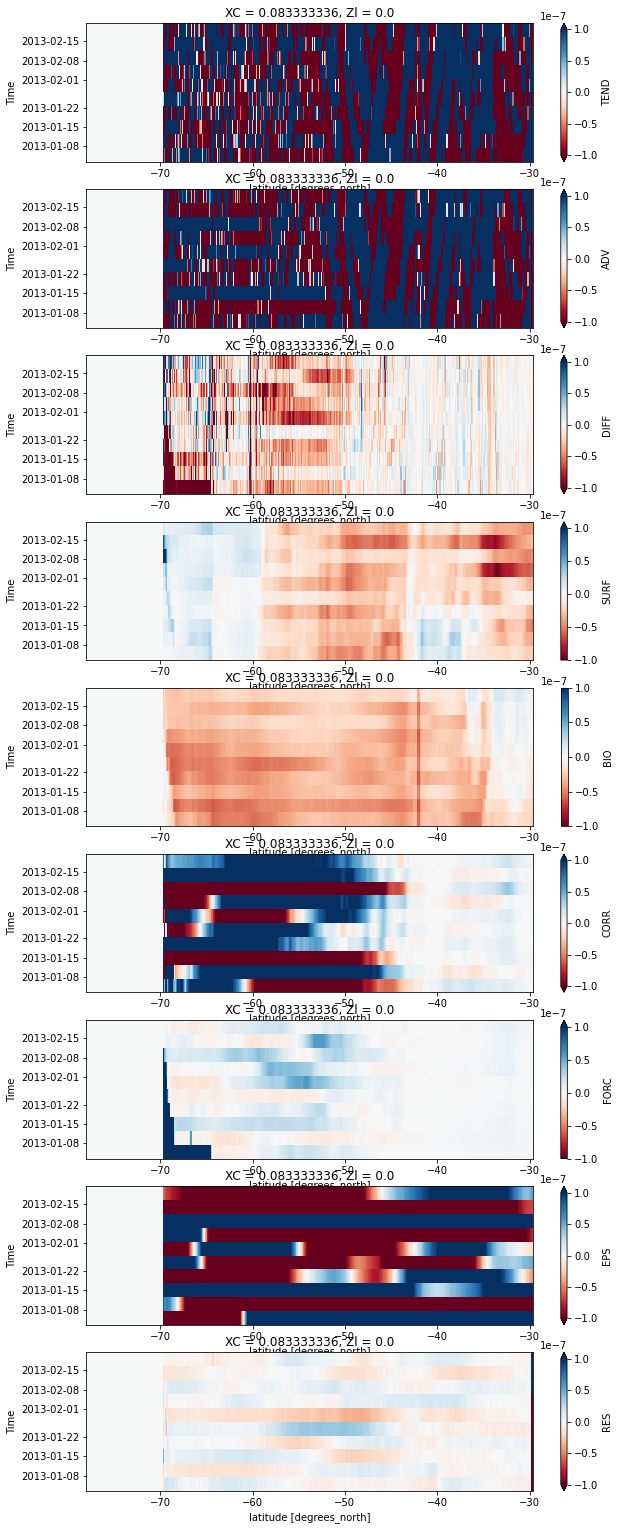

In [9]:
iselect = {'time':slice(0,10),'XC':0}
sums = ['Z']
kwargs = {'vmin':-1E-7,'vmax':1E-7,'cmap':'RdBu'}
terms = budget.data_vars
nt = len(terms)
fig,axarr=plt.subplots(figsize=(10,3*nt),nrows=nt)
for i,term in enumerate(terms):
    ax=axarr.flat[i]
    budget[term].isel(iselect).sum(sums).plot(ax=ax,**kwargs)    

In [ ]:
iselect = {'time':slice(0,12)}
select = {'YC':slice(-90,-50)}
sums = ['XC','YC','Z']
%time ts = budget.isel(iselect).sel(select).sum(sums).load()

In [17]:
select = {'YC':slice(-90,-50)}
sums = ['XC','YC','Z']
nt = 4
times = np.arange(nt)
tmp = xr.DataArray(np.zeros(shape=(nt,)),dims=['time'],coords={'time':budget['time'][0:nt]})
ts = xr.Dataset()
for term in budget.data_vars:
    print(term)
    for t in times:
        print(t)
        iselect = {'time':t}
        %time tmp[t] = budget[term].isel(iselect).sel(select).sum(sums)
#     ts[term] = tmp
# for t in range(nt):
#     budget.isel(iselect).sel(select).sum(sums).load()

TEND
0
CPU times: user 10.9 s, sys: 3.58 s, total: 14.5 s
Wall time: 8.63 s
1
CPU times: user 10.4 s, sys: 3.48 s, total: 13.8 s
Wall time: 8.26 s
2
CPU times: user 11 s, sys: 3.59 s, total: 14.5 s
Wall time: 8.45 s
3
CPU times: user 10.2 s, sys: 3.46 s, total: 13.7 s
Wall time: 8.17 s
ADV
0


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 7.04 s, sys: 3.79 s, total: 10.8 s
Wall time: 7.38 s
1


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 7.32 s, sys: 3.89 s, total: 11.2 s
Wall time: 7.6 s
2


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 7.57 s, sys: 3.95 s, total: 11.5 s
Wall time: 7.73 s
3


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 7.43 s, sys: 3.86 s, total: 11.3 s
Wall time: 7.7 s
DIFF
0


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 6.52 s, sys: 3.34 s, total: 9.86 s
Wall time: 6.94 s
1


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 6.67 s, sys: 3.63 s, total: 10.3 s
Wall time: 6.94 s
2


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 6.41 s, sys: 3.5 s, total: 9.91 s
Wall time: 7.21 s
3


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 6.87 s, sys: 3.79 s, total: 10.7 s
Wall time: 7.84 s
SURF
0


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 4.89 s, sys: 1.8 s, total: 6.69 s
Wall time: 5.8 s
1


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 5.27 s, sys: 1.95 s, total: 7.22 s
Wall time: 6.29 s
2


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 5.02 s, sys: 1.85 s, total: 6.87 s
Wall time: 6.01 s
3


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 4.91 s, sys: 1.61 s, total: 6.52 s
Wall time: 5.54 s
BIO
0
CPU times: user 4.78 s, sys: 1.87 s, total: 6.65 s
Wall time: 5.99 s
1
CPU times: user 4.47 s, sys: 1.74 s, total: 6.21 s
Wall time: 5.73 s
2
CPU times: user 4.63 s, sys: 1.87 s, total: 6.5 s
Wall time: 6.09 s
3
CPU times: user 4.69 s, sys: 1.77 s, total: 6.45 s
Wall time: 5.85 s
CORR
0


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 2.73 s, sys: 1.85 s, total: 4.58 s
Wall time: 3.98 s
1


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 2.96 s, sys: 2.08 s, total: 5.04 s
Wall time: 4.43 s
2


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 2.87 s, sys: 2.02 s, total: 4.88 s
Wall time: 4.48 s
3


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 2.98 s, sys: 2.16 s, total: 5.14 s
Wall time: 4.56 s
FORC
0
CPU times: user 1.8 s, sys: 1.14 s, total: 2.94 s
Wall time: 2.35 s
1
CPU times: user 1.97 s, sys: 1.18 s, total: 3.15 s
Wall time: 2.44 s
2
CPU times: user 1.78 s, sys: 1.03 s, total: 2.81 s
Wall time: 2.12 s
3
CPU times: user 1.69 s, sys: 1.02 s, total: 2.72 s
Wall time: 2.1 s
EPS
0
CPU times: user 2.01 s, sys: 1.22 s, total: 3.24 s
Wall time: 2.16 s
1
CPU times: user 1.83 s, sys: 1.18 s, total: 3.01 s
Wall time: 2.09 s
2
CPU times: user 1.92 s, sys: 1.16 s, total: 3.08 s
Wall time: 2.09 s
3
CPU times: user 1.8 s, sys: 1.11 s, total: 2.9 s
Wall time: 2.05 s
RES
0


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 41.9 s, sys: 15.8 s, total: 57.8 s
Wall time: 19.9 s
1


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 41.1 s, sys: 15.2 s, total: 56.3 s
Wall time: 19.8 s
2


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 42.1 s, sys: 15.5 s, total: 57.6 s
Wall time: 19.9 s
3


/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 41.2 s, sys: 15.1 s, total: 56.4 s
Wall time: 19.3 s


In [19]:
tmp

<xarray.DataArray (time: 4)>
array([-0.00701126, -0.00626718, -0.00358853, -0.00549612])
Coordinates:
  * time     (time) datetime64[ns] 2013-01-05 2013-01-10 2013-01-15 2013-01-20

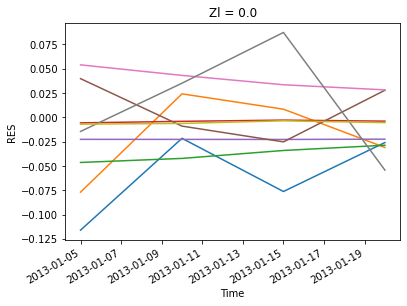

In [18]:
for term in ts.data_vars:
    ts[term].plot()